## D2L_08：线性回归的实现
这是d2l的08课的代码学习
[视频地址](https://www.bilibili.com/video/BV1PX4y1g7KC/)

In [1]:
import random
import torch
import matplotlib.pyplot as plt
#from d2l import torch as d2l

#### 最简单的实现
1. 准备数据

In [6]:
# 生成模拟数据  
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    print(X.shape)
    print(w.shape)
    print(y.shape)
    # 为了使数据更真实，加上一个随机干扰    
    y += torch.normal(0, 0.01, y.shape)
    return X, y

# true_w应该是列向量 这里为了和下边w一样统一列向量
true_w = torch.tensor([2.0, -4.1]).reshape(-1, 1)
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

torch.Size([1000, 2])
torch.Size([2, 1])
torch.Size([1000, 1])


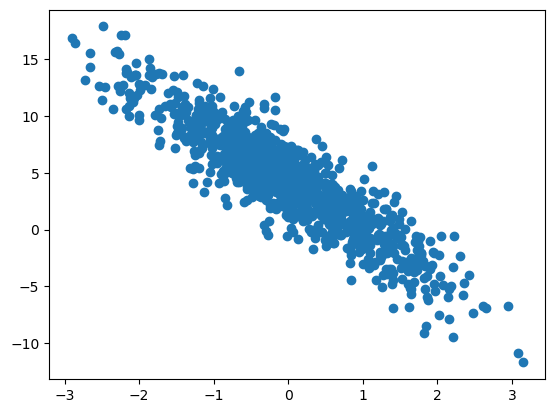

In [8]:
# y与x是线性关系的，由于w1的绝对值大，w1的线性强一些，所以x1与y的线性关系强一些
# 这里用散点图看一下y与x1的线性关系
plt.scatter(features[:, 1].numpy(), labels.numpy())
plt.show()

In [9]:
# 批量样本的生成器 每次调用next(g)，都会得到batch_size个数据
def data_iter(batch_size, features, labels):
    # 随机下样本索引     
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        start = i
        end = min(i + batch_size, num_examples)
        select = indices[start:end]
        yield features[select], labels[select]


2. 定义线性回归：即只有一层的神经网络

In [11]:

# 定义线性回归的模型
def linreg(X, w, b):
    return torch.matmul(X, w) + b

# 损失函数，均方误差，一般来说直接y_hat - y即可  如果行列不同reshape一下就行，
def square_loss(y_hat, y):
    return (y_hat - y) ** 2 / 2


# 优化算法 paramas是[w, b]，求导之后走这里来更新参数
def sgd(paramas, lr, batch_size):
    with torch.no_grad():
        for parama in paramas:
            # 因为之前的损失会把所有误差加起来，没有除以batch size 所以在梯度里除了，在损失求和那里除也可以
            parama -= lr * parama.grad  / batch_size
            parama.grad.zero_()



3. 开始训练

In [16]:
# 样本形状是(1, 2 )，输出是(1, 1)，因此权重的形状是(2,1)
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
lr = 0.03 # 学习率
num_epochs = 3 # 全部样本学习3次
net = linreg
loss = square_loss
batch_size = 15

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        # 运行网络计算预测值 这里y_hat是批量大小的矩阵
        y_hat = net(X, w, b)
        # 计算损失，这里的损失也是批量大小的
        l = square_loss(y_hat, y)
        
        # 计算梯度  这里如果用l的mean的话，下边sgd里就不需要除以len(l)了
        l.sum().backward()
        # 根据梯度修正w b
        sgd([w, b], lr, len(l))
    
    #运行完一遍样本，跑一边真实数据算一下损失
    with torch.no_grad():
        true_l = loss(net(features, w, b), labels)
        true_l = true_l.mean()
        print(f'epoch: {epoch}, loss: {float(true_l):.5f}')

# 最后比较下w b 与我们设定的true w b 
print(f'w loss: f{true_w - w}')
print(f'b loss: f{true_b - b}')

epoch: 0, loss: 0.33237
epoch: 1, loss: 0.00591
epoch: 2, loss: 0.00015
w loss: ftensor([[ 0.0058],
        [-0.0081]], grad_fn=<SubBackward0>)
b loss: ftensor([0.0102], grad_fn=<RsubBackward1>)


#### pytorch的框架实现
1. 数据加载

In [17]:
from torch.utils import data
from torch import nn

In [18]:
# 利用torch的data进行加载批量数据
def data_iter_torch(data_array, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_array)
    data_loader = data.DataLoader(dataset, batch_size, shuffle=is_train)
    # 返回生成器 和上边的data_iter一样
    return iter(data_loader)


2. 定义网络

In [20]:
# 我们用线性网络，输入是2，输出是1，放到一个Sequential里
# Sequential大概就是我们神经网络的层
net_torch = nn.Sequential(nn.Linear(2, 1))


# 误差函数 直接用自带的均方误差
loss_torch = nn.MSELoss()
# 优化函数 自带的SDG
lr = 0.03
trainer = torch.optim.SGD(net_torch.parameters(), lr=lr) 

3. 开始训练

In [28]:
# 初始化网络的参数 w b
net_torch[0].weight.data.normal_(0, 0.01)
net_torch[0].bias.data.fill_(0)

num_epochs = 3 
batch_size = 10
for epoch in range(num_epochs):
    for X, y in data_iter_torch((features, labels), batch_size):
        l = loss_torch(net_torch(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss_torch(net_torch(features), labels)
    print(f'epoch: f{epoch}, loss: {l:.5f}')
print(f'w loss: f{true_w - net_torch[0].weight.data.reshape (true_w.shape)}')
print(f'b loss: f{true_b - net_torch[0].bias.data}')


epoch: f0, loss: 0.00028
epoch: f1, loss: 0.00010
epoch: f2, loss: 0.00010
w loss: ftensor([[-0.0001],
        [-0.0002]])
b loss: ftensor([0.0003])
